In [613]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import expon
from scipy.stats import uniform
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.special import erf
from scipy.special import hyp1f1
from scipy.linalg import eigh
from random import randint
from scipy.optimize import fsolve
from scipy.optimize import root
from numpy.polynomial import legendre

## simulation

In [614]:
def intensity(t,history,parameters):    #left continue
    mu_1=parameters[0]
    mu_2=parameters[1]
    alpha=parameters[2]
    beta=parameters[3]
    intensity=0
    for i in range(len(history)):
        if history[i]>=t:
            break
        intensity+=alpha*np.exp(-beta*(t-history[i]))
    if t<0.5*T:
        return mu_1+intensity
    else:
        return mu_2+intensity

In [615]:
def hawkes_simulation_expo_piece_mu(T,parameters):
    t=0
    jump=0
    points_homo=[]
    points_hawkes=[]
    while(t<T):
        points_homo.append(t)
        intensity_sup=intensity(t,points_hawkes,parameters)+jump
        r=expon.rvs(scale=1/intensity_sup) #scale=1/lamda
        t+=r
        D=uniform.rvs(loc=0,scale=1)
        intensity_t=intensity(t,points_hawkes,parameters)
        assert intensity_t<=intensity_sup, 'Houst'
        if D*intensity_sup<=intensity_t:
            points_hawkes.append(t)
            jump=parameters[1]
        else:
            jump=0
    if points_hawkes[-1]>T:
        del points_hawkes[-1]
    del points_homo[0]
    return points_hawkes

In [715]:
T=100

In [716]:
points_hawkes=[]

In [732]:
points_hawkes.append(hawkes_simulation_expo_piece_mu(T,[1,2,1,2]))

In [733]:
len(points_hawkes)

10

In [734]:
def negtiveloglikelyhood1(parameters, times, T): #times=timestamp t1-tn; T is timespan      fast:R(i)
    times=np.array(times)
    
    mu=parameters[0]
    alpha=parameters[1]
    beta=parameters[2]
    
    timedifference=T-times #T-t0...T-t(n-1) 
    timeexponential=np.exp(-beta*timedifference)-1
    secondsum=alpha/beta*sum(timeexponential)
    
    R=np.zeros((len(times),1))
    for i in range(1,len(times)):
        R[i]=np.exp(-beta*(times[i]-times[i-1]))*(1+R[i-1])
    firstsum=sum(np.log(mu+alpha*R))  #left-continuous
    
    negtivelogl=-(firstsum-mu*T+secondsum)
    return negtivelogl

In [735]:
res=[]

In [736]:
for i in range(10):
    parameters=np.array([1.2,0.7,3])
    result=optimize.minimize(negtiveloglikelyhood1, parameters,args=(points_hawkes[i],T), method='SLSQP', bounds=((0.01,5),(0.01,5),(0.01,5)), options={'disp': True})
    res.append(result.x)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -33.30226142830692
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -74.48724532844903
            Iterations: 10
            Function evaluations: 54
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -109.72869319690867
            Iterations: 12
            Function evaluations: 64
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -41.29477444740402
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -104.91972696093882
            Iterations: 12
            Functio

In [737]:
res_ave=np.average(res,axis=0)

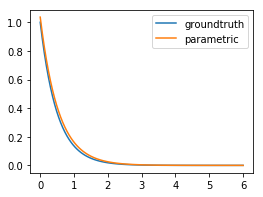

In [738]:
plt.figure(1,figsize=(4,3))
axs=plt.subplot(111)
axs.plot(np.linspace(0,6,100),1*np.exp(-2*np.linspace(0,6,100)),label='groundtruth')
axs.plot(np.linspace(0,6,100),res_ave[1]*np.exp(-res_ave[2]*np.linspace(0,6,100)),label='parametric')
plt.legend()
plt.show()

## inference

In [739]:
def expo_quad_kernel(theta0,theta1,xn,xm):
    return theta0*np.exp(-theta1/2*np.sum((xn - xm)**2))

In [740]:
def GP_regression(xi,yi,theta0,theta1,noise_var,rang,num_points):
    N=len(xi)
    cov_K=np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            cov_K[i][j]=expo_quad_kernel(theta0,theta1,xi[i],xi[j])
            cov_K[j][i]=cov_K[i][j]
    min_eig=np.min(np.real(np.linalg.eigvals(cov_K))) # numerical float truncation error refine
    while(min_eig<0):
        cov_K += -10*min_eig*np.eye(cov_K.shape[0])
        min_eig=np.min(np.real(np.linalg.eigvals(cov_K)))
    
    cov_K_noise=cov_K+np.eye(N)*noise_var
    
    x1=np.linspace(0,rang,num_points+1)      # prediction points, integer is to make it easy
    M=len(x1)-1
    mean=np.zeros((1,M))[0]
    posterior_cov=np.zeros((M,M))
    k_matrix=np.zeros((M,N))
    k_matrix_pre=np.zeros((M,M))
    for i in range(M):
        for j in range(N):
            k_matrix[i][j]=expo_quad_kernel(theta0,theta1,x1[i],xi[j])
    k_C=np.dot(k_matrix,np.linalg.inv(cov_K_noise))
    mean=np.dot(k_C,yi)
    for i in range(M):
        for j in range(i,M):
            k_matrix_pre[i][j]=expo_quad_kernel(theta0,theta1,x1[i],x1[j])
            k_matrix_pre[j][i]=k_matrix_pre[i][j]
    posterior_cov=k_matrix_pre-np.dot(k_C,k_matrix.T)+np.eye(M)*noise_var
    min_eig=np.min(np.real(np.linalg.eigvals(posterior_cov))) # numerical float truncation error refine
    while(min_eig<0):
        posterior_cov += -10*min_eig*np.eye(posterior_cov.shape[0])
        min_eig=np.min(np.real(np.linalg.eigvals(posterior_cov)))
    return x1[:num_points],mean, posterior_cov

In [741]:
def u_generate(theta0,theta1,xi): # xi is inducing points, N(0,Sigma)
    N=len(xi)
    cov=np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            cov[i][j]=expo_quad_kernel(theta0,theta1,xi[i],xi[j])
            cov[j][i]=cov[i][j]
    return multivariate_normal([0]*N,cov).rvs(),np.array([0]*N),cov

In [742]:
T_phi=6

In [743]:
xi=np.linspace(0+(T_phi/10)/2,T_phi-(T_phi/10)/2,6)   # 6 inducing points on \phi(\tau)

In [744]:
xi_mu=np.linspace(0,T,8)   # 8 inducing points, T is larger so we need more points

In [745]:
theta0=1
theta1=0.5

In [746]:
u,mean_p_u,cov_p_u=u_generate(theta0,theta1,xi)

In [747]:
f=GP_regression(xi,u,theta0,theta1,0.000001,T_phi,100) # f is 100-dimension vector on [0,T_phi]

In [748]:
def eq(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M,m):
    y=0
    s=p
    for i in range(1,len(k_K_k)):
        for j in range(i):
            if P[i][j]!=0:
                y+=k_K_K_k[i][j][m]*P[i][j]/(k_K_k[i][j]+sum([(k_K[i][j][k]**2)*s[k] for k in range(M)]))
    y+=-secondterm[m]-0.5*thirdterm[m]+0.5/s[m]
    return y

In [749]:
def equations(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M):
    return [eq(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M,i) for i in range(M)]

In [750]:
def ini_P(points_hawkes,T_phi):
    N=len(points_hawkes)
    P=np.zeros((N,N))
    for i in range(N):                    # initial value of P
        for j in range(i+1):
            tij=points_hawkes[i]-points_hawkes[j]
            if tij>=T_phi:continue
            else:
                P[i][j:i+1]=np.random.dirichlet([1]*(i-j+1))
                break
    return P

In [751]:
def psi(theta0,theta1,xn,xm,T):
    x_mean=(xn+xm)/2
    return (theta0**2)*(-np.sqrt(np.pi/theta1)/2)*np.exp((-theta1*(xn-xm)**2)/4)*(erf((x_mean-T)*np.sqrt(theta1))\
                                                                                  -erf(x_mean*np.sqrt(theta1)))

In [752]:
def distribution_f_posterior(x_f,xi,theta0,theta1,cov_p_u,cov_q_u_post):
    N=len(xi) # N is number of inducing points
    M=len(x_f) # M is number of predicting points
    
    cov_p_u_inv=np.linalg.inv(cov_p_u)
    
    K_xz=np.zeros((M,N))
    for i in range(M):
        for j in range(N):
            K_xz[i][j]=expo_quad_kernel(theta0,theta1,x_f[i],xi[j])
#     K_xx=np.zeros((M,M))
#     for i in range(M):
#         for j in range(i,M):
#             K_xx[i][j]=expo_quad_kernel(theta0,theta1,x_f[i],x_f[j])
#             K_xx[j][i]=K_xx[i][j]
#     mean_f=(K_xz.dot(cov_p_u_inv)).dot(mean_q_u_post)
#     cov_f=K_xx-(K_xz.dot(cov_p_u_inv)).dot(K_xz.T)+(((K_xz.dot(cov_p_u_inv)).dot(cov_q_u_post)).dot(cov_p_u_inv)).dot(K_xz.T)
    var_f=np.array([theta0-K_xz[i].dot(cov_p_u_inv).dot(K_xz[i].T)+(((K_xz[i].dot(cov_p_u_inv)).dot(cov_q_u_post)).dot(cov_p_u_inv)).dot(K_xz[i].T) for i in range(M)])
    
    exp_phi=var_f
    return exp_phi

In [753]:
theta0_mu=1
theta1_mu=0.02

In [754]:
u_mu,mean_p_u_mu,cov_p_u_mu=u_generate(theta0_mu,theta1_mu,xi_mu)

In [755]:
f_mu=GP_regression(xi_mu,u_mu,theta0_mu,theta1_mu,0.000001,T,500) # f is 1000-dimension vector on [0,T]

In [756]:
def eq_mu(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M,m):
    y=0
    s=p
    for n in range(len(k_K_k)):
        if P[n][n]!=0:
            y+=k_K_K_k[n][m]*P[n][n]/(k_K_k[n]+sum([(k_K[n][i]**2)*s[i] for i in range(M)]))
    y+=-secondterm[m]-0.5*thirdterm[m]+0.5/s[m]
    return y

In [757]:
def equations_mu(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M):
    return [eq_mu(p,P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M,i) for i in range(M)]

In [758]:
def MISD_variational_deri(points_hawkes,xi,xi_mu,T_phi,T,num_iter): # 100 predict points on T_phi, 1000 predict points on T
    N=len(points_hawkes) # num of observation
    M=len(xi)            # num of inducing points on phi
    M_mu=len(xi_mu)      # num of inducing points on mu
    P=ini_P(points_hawkes,T_phi)
    delta_t=T_phi/len(f[0]) # phi is discete to 100 points
    delta_t_mu=T/len(f_mu[0]) # u(t) is descrete to 500 points
    
    
    #_______________________initial setting of mu
    cov_q_u_mu_diag=np.random.uniform(0,1,M_mu)  ## initial of cov_q_u_mu_diag
    k_tn_z_mu=np.zeros((N,M_mu))
    for i in range(N):
        for j in range(M_mu):
            k_tn_z_mu[i][j]=expo_quad_kernel(theta0_mu,theta1_mu,points_hawkes[i],xi_mu[j])
            
    cov_p_u_mu_inv=np.linalg.inv(cov_p_u_mu)
    thirdterm_mu=np.diagonal(cov_p_u_mu_inv)
    Psi_mu=np.zeros((M_mu,M_mu))
    for i in range(M_mu):
        for j in range(i,M_mu):
            Psi_mu[i][j]=psi(theta0_mu,theta1_mu,xi_mu[i],xi_mu[j],T)
            Psi_mu[j][i]=Psi_mu[i][j]
    secondterm_mu=np.diagonal(cov_p_u_mu_inv.dot(Psi_mu).dot(cov_p_u_mu_inv))
    
    k_K_K_k_mu=np.empty((0,M_mu))   #vector of vector   #     1st term
    k_K_k_mu=np.array([])    # vecotr of value
    k_K_mu=np.empty((0,M_mu))      # vector of vector
    for i in range(N):
        k_K_K_k_mu=np.append(k_K_K_k_mu, np.array([np.diagonal(cov_p_u_mu_inv.dot(np.array([k_tn_z_mu[i]]).T).dot(np.array([k_tn_z_mu[i]])).dot(cov_p_u_mu_inv))]),axis=0)
        k_K_k_mu=np.append(k_K_k_mu,theta0_mu-k_tn_z_mu[i].dot(cov_p_u_mu_inv).dot(k_tn_z_mu[i].T))
        k_K_mu=np.append(k_K_mu,np.array([k_tn_z_mu[i].dot(cov_p_u_mu_inv)]),axis=0) 
    
    #__________________initial setting of phi
    cov_q_u_diag=np.random.uniform(0,1,M)
    cov_p_u_inv=np.linalg.inv(cov_p_u)
    thirdterm=np.diagonal(cov_p_u_inv)
    n_1=sum(np.array(points_hawkes)<(T-T_phi)) # num of points within T-T_phi
    Psi=np.zeros((N,M,M))
    for i in range(n_1):
        for j in range(M):
            for k in range(j,M):
                Psi[i][j][k]=psi(theta0,theta1,xi[j],xi[k],T_phi)
                Psi[i][k][j]=Psi[i][j][k]
    for i in range(n_1,N):
        for j in range(M):
            for k in range(j,M):
                Psi[i][j][k]=psi(theta0,theta1,xi[j],xi[k],T-points_hawkes[i])
                Psi[i][k][j]=Psi[i][j][k]
    secondterm=sum([np.diagonal(cov_p_u_inv.dot(Psi[i]).dot(cov_p_u_inv)) for i in range(N)])
    k_tn_z=np.zeros((N,N,M))
    for i in range(1,N):
        for j in range(i):
            if P[i][j]!=0:
                tao=points_hawkes[i]-points_hawkes[j]
                k_tn_z[i][j]=np.array([expo_quad_kernel(theta0,theta1,tao,xi[k]) for k in range(M)])            
    k_K_K_k=np.zeros((N,N,M))   # matrix of vector   #     1st term
    k_K_k=np.zeros((N,N))    # matrix of value
    k_K=np.zeros((N,N,M))     # matrix of vector
    for i in range(1,N):
        for j in range(i):
            if P[i][j]!=0:
                k_K_K_k[i][j]=np.diagonal(cov_p_u_inv.dot(np.array([k_tn_z[i][j]]).T).dot(np.array([k_tn_z[i][j]])).dot(cov_p_u_inv))
                k_K_k[i][j]=theta0-k_tn_z[i][j].dot(cov_p_u_inv).dot(k_tn_z[i][j].T)
                k_K[i][j]=k_tn_z[i][j].dot(cov_p_u_inv)
    
    
    
    
    
    for k in range(num_iter):  # num of iterations
        # update of phi
        
        cov_q_u_diag=fsolve(equations,cov_q_u_diag, args=(P,k_K,k_K_k,k_K_K_k,secondterm,thirdterm,M))
        cov_q_u_diag[cov_q_u_diag<0] = 0.1 # more stable
        cov_q_u=np.diag(cov_q_u_diag)
        phi=distribution_f_posterior(f[0],xi,theta0,theta1,cov_p_u,cov_q_u)
        
        # update of mu
        
        cov_q_u_mu_diag=fsolve(equations_mu,cov_q_u_mu_diag, args=(P,k_K_mu,k_K_k_mu,k_K_K_k_mu,secondterm_mu,thirdterm_mu,M_mu))
        cov_q_u_mu_diag[cov_q_u_mu_diag<0] = 0.1 # more stable
        cov_q_u_mu=np.diag(cov_q_u_mu_diag)
        mu=distribution_f_posterior(f_mu[0],xi_mu,theta0_mu,theta1_mu,cov_p_u_mu,cov_q_u_mu)

        
        for i in range(N): # updata of P
            mu_ti=mu[int(points_hawkes[i]/delta_t_mu)]
            intensity_total=0
            for j in range(i):
                tji=points_hawkes[i]-points_hawkes[j]
                if tji>=T_phi: continue
                intensity_total+=phi[int(tji/delta_t)]
            intensity_total+=mu_ti
            P[i][i]=mu_ti/intensity_total
            for j in range(i):
                tji=points_hawkes[i]-points_hawkes[j]
                if tji>=T_phi: P[i][j]=0
                else: P[i][j]=phi[int(tji/delta_t)]/intensity_total
    return mu,phi

In [759]:
mu_var_list=[]
phi_var_list=[]

In [760]:
%%time
for i in range(10):
    mu_var,phi_var=MISD_variational_deri(points_hawkes[i],xi,xi_mu,T_phi,T,100)
    mu_var_list.append(mu_var)
    phi_var_list.append(phi_var)

C:\Users\zho045\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Wall time: 2h 4min 31s


In [818]:
mu_var_ave=np.average(mu_var_list,axis=0)

In [819]:
phi_var_ave=np.average(phi_var_list,axis=0)

In [820]:
# import pandas as pd
# test=pd.DataFrame(data=points_hawkes)
# test.to_csv('./case_2.csv',encoding='gbk')

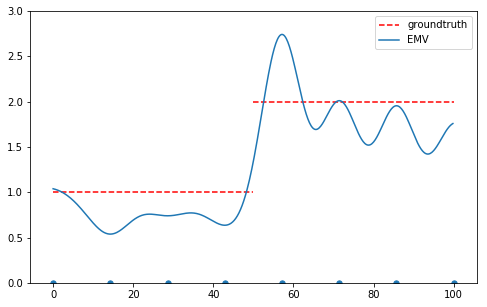

In [821]:
plt.figure(1,figsize=(8,5))
axs=plt.subplot(111)
axs.plot([0,T/2],[1,1],'r--',label='groundtruth')
axs.plot([T/2,T],[2,2],'r--')
axs.plot(f_mu[0],mu_var_ave,label='EMV')
axs.scatter(xi_mu,np.zeros((len(xi_mu))),marker='o',s=28)
plt.legend()
plt.ylim(0,3)
plt.show()

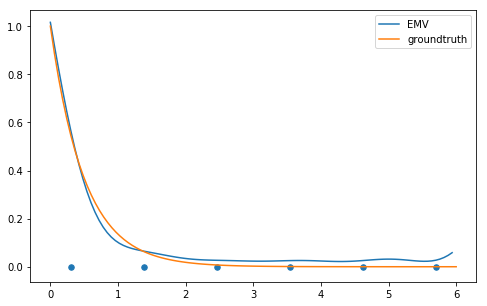

In [793]:
plt.figure(1,figsize=(8,5))
axs=plt.subplot(111)
axs.plot(f[0],phi_var_ave,label='EMV')
axs.plot(np.linspace(0,6,100),1*np.exp(-2*np.linspace(0,6,100)),label='groundtruth')
axs.scatter(xi,np.zeros((len(xi))),marker='o',s=30)
plt.legend()
plt.show()

In [794]:
def MISD(points_hawkes,T,T_gamma,delta_t,num_iter):
    num_g=int(T_gamma/delta_t)
    N=len(points_hawkes)
    P=ini_P(points_hawkes,T_gamma)
    g=np.zeros((1,num_g), dtype=float)

    for k in range(num_iter):
        for m in range(num_g): # update for u and g
            rate_prob=np.zeros((1,N))
            div_num=0
            for i in range(N):
                if (T-points_hawkes[i])>=m*delta_t and (T-points_hawkes[i])<(m+1)*delta_t: # point i is close to T
                    div_num+=1
                    for j in range(i+1,N):
                        interval=points_hawkes[j]-points_hawkes[i]
                        if interval>=m*delta_t and interval<(m+1)*delta_t:
                            rate_prob[0][i]+=P[j][i]
                        elif interval>=(m+1)*delta_t:
                            break
                    rate_prob[0][i]=rate_prob[0][i]/(T-m*delta_t)
                elif (T-points_hawkes[i])<m*delta_t:
                    break
                else:
                    div_num+=1
                    for j in range(i+1,N):
                        interval=points_hawkes[j]-points_hawkes[i]
                        if interval>=m*delta_t and interval<(m+1)*delta_t:
                            rate_prob[0][i]+=P[j][i]
                        elif interval>=(m+1)*delta_t:
                            break
                    rate_prob[0][i]=rate_prob[0][i]/delta_t
            if div_num==0:
                break
            else:
                g[0][m]=sum(rate_prob[0])/div_num
        u=sum(P[i][i] for i in range(N))/T

        for i in range(N): # updata for P
            intensity_total=0
            for j in range(i):
                tji=points_hawkes[i]-points_hawkes[j]
                if tji>=T_gamma: continue
                intensity_total+=g[0][int(tji/delta_t)]
            intensity_total+=u
            P[i][i]=u/intensity_total
            for j in range(i):
                tji=points_hawkes[i]-points_hawkes[j]
                if tji>=T_gamma: P[i][j]=0
                else: P[i][j]=g[0][int(tji/delta_t)]/intensity_total
    return u,g[0]

In [795]:
u_misd_10_list=[]
phi_misd_10_list=[]

In [796]:
for i in range(10):
    u_misd_10,phi_misd_10=MISD(points_hawkes[i],T,T_phi,0.6,200)
    u_misd_10_list.append(u_misd_10)
    phi_misd_10_list.append(phi_misd_10)

In [799]:
u_misd_10_ave=np.average(u_misd_10_list)
phi_misd_10_ave=np.average(phi_misd_10_list,axis=0)

In [800]:
u_misd_20_list=[]
phi_misd_20_list=[]

In [801]:
for i in range(10):
    u_misd_20,phi_misd_20=MISD(points_hawkes[i],T,T_phi,0.3,200)
    u_misd_20_list.append(u_misd_20)
    phi_misd_20_list.append(phi_misd_20)

In [803]:
u_misd_20_ave=np.average(u_misd_20_list)
phi_misd_20_ave=np.average(phi_misd_20_list,axis=0)

In [804]:
def hawkes_second_stats_conti_gauss(t,h,points_hawkes,T):   # gaussian kernel
    N=len(points_hawkes)
    Lamda=N/T
    g_t_i=[]
    for i in range(N):
        if points_hawkes[i]+t>T-h:
            break
        else:
            g_t=np.exp(-(((t-(points_hawkes[:i]+points_hawkes[i+1:]-points_hawkes[i]))/h)**2/2))
            g_t_i.append(sum(g_t)/np.sqrt(2*np.pi)/h)
    return np.average(g_t_i)-Lamda

In [805]:
def primitive_g(t,g,range_g): # -infinity to t
    delta_t=range_g/len(g)
    num_bin=t/delta_t
    if num_bin<len(g):
        integral=sum(g[:int(num_bin)])*delta_t+g[int(num_bin)]*delta_t*(num_bin-int(num_bin))
    else:
        integral=sum(g)*delta_t
    return integral+sum(g)*delta_t

In [806]:
def gq_points_weights(a,b,Q):
    p,w=np.polynomial.legendre.leggauss(Q)
    c = np.array([0]*Q + [1])
    p_new=(a+b+(b-a)*p)/2
    w_new=(b-a)/(legendre.legval(p, legendre.legder(c))**2*(1-p**2))
    return p_new,w_new

In [807]:
def phi_WH_prediction(t,g,Q,range_g): 
    delta_t=range_g/len(g) 
    p,w=gq_points_weights(0,range_g,Q)  # (0,infininty) replaced by (0,range_g)
    g_ti=np.zeros((Q,Q))
    G_ti=np.zeros((1,Q))[0]
    for i in range(Q):
        G_ti[i]=primitive_g(p[i],g,range_g)
        for j in range(i,Q):
            if i==j:
                g_ti[i][i]=g[int(p[i]/delta_t)]
            else:
                g_ti[i][j]=g[int((p[j]-p[i])/delta_t)]
                g_ti[j][i]=g_ti[i][j]
    
    a = np.zeros((Q,Q))
    b = np.zeros((1,Q))[0]
    for i in range(Q):
        b[i]=g_ti[i][i]
        for j in range(Q):
            if i==j:
                a[i][i]=1+G_ti[i]-sum(w*g_ti[i])+w[i]*g_ti[i][i]  #diagonal
            else:
                a[i][j]=w[j]*g_ti[i][j]    
    phi_ti = np.linalg.solve(a,b)

    g_t=g[int(t/delta_t)]
    G_t=primitive_g(t,g,range_g)
    g_t_ti=np.zeros((1,Q))[0]
    for i in range(Q):
        g_t_ti[i]=g[int((t-p[i])/delta_t)]
    phi_t=(g_t-sum(w*phi_ti*g_t_ti))/(1+G_t-sum(w*g_t_ti))
    return phi_t

In [808]:
def phi_parameter(x,points_hawkes,h,Q,range_g):# default range_g*10 points
#     x=np.linspace(0.1/2,range_g-0.1/2,range_g*10)
    g_gauss=[hawkes_second_stats_conti_gauss(x_i,h,points_hawkes,T) for x_i in x]
    phi_result=[phi_WH_prediction(xi,g_gauss,Q,range_g) for xi in x]
    
#     mse=sum((np.array(phi_result)-1*np.exp(-2*x))**2)/(range_g*10)
    return phi_result

In [809]:
u_wh_list=[]
phi_wh_list=[]

In [810]:
for i in range(10):
    phi_wh=phi_parameter(f[0],points_hawkes[i],1,100,T_phi)
    u_wh=len(points_hawkes[i])/T*(1-sum(T_phi/len(f[0])*np.array(phi_wh)))
    u_wh_list.append(u_wh)
    phi_wh_list.append(phi_wh)

In [811]:
u_wh_ave=np.average(u_wh_list)
phi_wh_ave=np.average(phi_wh_list,axis=0)

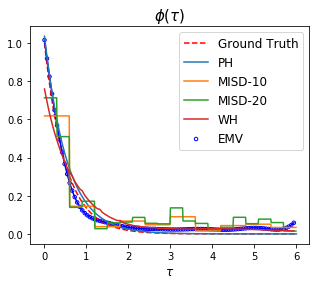

In [824]:
plt.figure(1,figsize=(5,4))
axs=plt.subplot(111)
axs.plot(np.linspace(0,6,100),1*np.exp(-2*np.linspace(0,6,100)),'r--',label='Ground Truth')
axs.plot(f[0],phi_var_ave,'b')
axs.scatter(f[0],phi_var_ave,marker='o',s=12,c='',edgecolors='b',label='EMV')
axs.plot(np.linspace(0,6,100),res_ave[1]*np.exp(-res_ave[2]*np.linspace(0,6,100)),'-',label='PH')
axs.plot(np.linspace(0,6,600,endpoint=False),[phi_misd_10_ave[int(xxx/0.6)] for xxx in np.linspace(0,6,600,endpoint=False)],label='MISD-10')
axs.plot(np.linspace(0,6,600,endpoint=False),[phi_misd_20_ave[int(xxx/0.3)] for xxx in np.linspace(0,6,600,endpoint=False)],label='MISD-20')
axs.plot(f[0],phi_wh_ave,label='WH')
plt.xlabel(r'$\tau$',fontsize=12)
plt.title(r'$\phi(\tau)$',fontsize=15)
plt.legend(fontsize=12)

plt.savefig('c:/Users/zho045/Desktop/phi_case_2',bbox_inches = 'tight')
plt.show()

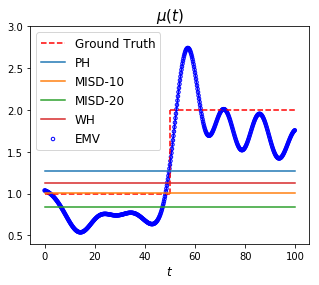

In [826]:
plt.figure(1,figsize=(5,4))
axs=plt.subplot(111)
axs.plot([0,T/2],[1,1],'r--',label='Ground Truth')
axs.plot([T/2,T/2],[1,2],'r--')
axs.plot([T/2,T],[2,2],'r--')
axs.plot(f_mu[0],mu_var_ave,'b')
axs.scatter(f_mu[0],mu_var_ave,marker='o',s=12,c='',edgecolors='b',label='EMV')
axs.plot([0,T],[res_ave[0],res_ave[0]],label='PH')
axs.plot([0,T],[u_misd_10_ave,u_misd_10_ave],label='MISD-10')
axs.plot([0,T],[u_misd_20_ave,u_misd_20_ave],label='MISD-20')
axs.plot([0,T],[u_wh_ave,u_wh_ave],label='WH')
plt.xlabel(r'$t$',fontsize=12)
plt.title(r'$\mu(t)$',fontsize=15)
plt.legend(fontsize=12)
plt.ylim(0.4,3)

plt.savefig('c:/Users/zho045/Desktop/phi_case_2_mu',bbox_inches = 'tight')
plt.show()

## EstErr

In [413]:
1**2/(2*2)+res.x[1]**2/(2*res.x[2])-2*1*res.x[1]/(2+res.x[2])

0.015342179189567262

In [414]:
sum((1*np.exp(-2*f[0])-phi_var)**2*(T_phi/len(f[0])))

0.0024803168574915675

In [415]:
sum((1*np.exp(-2*f[0])-phi_wh)**2*(T_phi/len(f[0])))

0.013140581590821801

In [416]:
sum((1*np.exp(-2*f[0])-(np.array([phi_misd_10[int(xxx/0.6)] for xxx in np.linspace(0,6,100,endpoint=False)])))**2*(T_phi/len(f[0])))

0.04307229378886008

In [417]:
sum((1*np.exp(-2*f[0])-(np.array([phi_misd_20[int(xxx/0.3)] for xxx in np.linspace(0,6,100,endpoint=False)])))**2*(T_phi/len(f[0])))

0.058071496497116

In [418]:
sum((res.x[0]-np.array([1]*250+[2]*250))**2*T/len(mu_var))

64.36245776108242

In [419]:
sum((mu_var-np.array([1]*250+[2]*250))**2*T/len(mu_var))

10.946281965467985

In [420]:
sum((u_wh-np.array([1]*250+[2]*250))**2*T/len(mu_var))

83.88348100872265

In [421]:
sum((u_misd_10-np.array([1]*250+[2]*250))**2*T/len(mu_var))

72.8474125654692

In [422]:
sum((u_misd_20-np.array([1]*250+[2]*250))**2*T/len(mu_var))

81.00845075951823

## logLik

In [425]:
def intensity_discrete(t,history,u,g_mean,T_phi):    #left continue, the intensity is a gaussian dist
    mu=u
    N=len(g_mean)
    intensity_mean=0
    for i in range(len(history)):
        if history[i]>=t:
            break
        delta_t=t-history[i]
        if delta_t<T_phi:
            intensity_mean+=g_mean[int(delta_t*N/T_phi)]
    return mu+intensity_mean

In [426]:
def negtiveloglikelihood_discrete(u,g_mean,times,T_phi,T):
    N=len(times)
    M=len(g_mean)
    logl=0
    for i in range(N):
        logl+=np.log(intensity_discrete(times[i],times,u,g_mean,T_phi))
        delta_t=T-times[i]
        if delta_t>=T_phi:
            logl-=sum(g_mean*T_phi/M)
        else:
            temp=(delta_t)*M/T_phi
            temp_int=int(temp)
            logl-=sum(g_mean[:temp_int]*T_phi/M)+g_mean[temp_int]*T_phi/M*(temp-temp_int)
    return -(logl-u*T)

In [427]:
def intensity_discrete_phi_mu(t,history,u,g_mean,g_range,T):    #left continue
    mu=u
    N=len(g_mean)
    M=len(mu)
    intensity_mean=0
    for i in range(len(history)):
        if history[i]>=t:
            break
        delta_t=t-history[i]
        if delta_t<g_range:
            intensity_mean+=g_mean[int(delta_t*N/g_range)]
    result=mu[int(t/T*M)]+intensity_mean
    return result

In [428]:
def negtiveloglikelihood_discrete_phi_mu(u,g_mean,g_range,times,T):
    N=len(times)
    M=len(g_mean)
    logl=0
    for i in range(N):
        logl+=np.log(intensity_discrete_phi_mu(times[i],times,u,g_mean,g_range,T))
        delta_t=T-times[i]
        if delta_t>=g_range:
            logl-=sum(g_mean*g_range/M)
        else:
            temp=(delta_t)*M/g_range
            temp_int=int(temp)
            logl-=sum(g_mean[:temp_int]*g_range/M)+g_mean[temp_int]*g_range/M*(temp-temp_int)
    return -(logl-sum(u*T/len(u)))

In [442]:
points_hawkes_test=[]

In [456]:
points_hawkes_test.append(hawkes_simulation_expo_piece_mu(T,[1,2,1,2]))

In [458]:
logLik_PH=[]
for i in range(10):
    logLik_PH.append(-negtiveloglikelyhood1(res.x, points_hawkes_test[i], T))

In [459]:
np.average(logLik_PH)

93.64346917700998

In [460]:
logLik_misd_10=[]
for i in range(10):
    logLik_misd_10.append(-negtiveloglikelihood_discrete(u_misd_10,phi_misd_10,points_hawkes_test[i],T_phi,T))

In [461]:
np.average(logLik_misd_10)

91.91197135148049

In [462]:
logLik_misd_20=[]
for i in range(10):
    logLik_misd_20.append(-negtiveloglikelihood_discrete(u_misd_20,phi_misd_20,points_hawkes_test[i],T_phi,T))

In [463]:
np.average(logLik_misd_20)

90.93822753258301

In [464]:
logLik_wh=[]
for i in range(10):
    logLik_wh.append(-negtiveloglikelihood_discrete(u_wh,np.array(phi_wh),points_hawkes_test[i],T_phi,T))

In [465]:
np.average(logLik_wh)

93.72298480091229

In [466]:
logLik_var=[]
for i in range(10):
    logLik_var.append(-negtiveloglikelihood_discrete_phi_mu(mu_var,phi_var,T_phi,points_hawkes_test[i],T))

In [467]:
np.average(logLik_var)

96.85073209299894